## 🕵️ Shoplifting Detection Using a Video Classifier

In [1]:
import cv2
import torch
import numpy as np
import torchvision
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from collections import deque, defaultdict
from ultralytics import YOLO
from IPython.display import Video
import albumentations as A

c:\Users\Anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 💾 The Dataset

Model is trained on a specialized dataset of pre-processed video clips showing two classes: **shoplifting** and **normal customer behavior**.

* All videos are clipped to a uniform length of **16 frames** (originally 2-3 seconds long) to match the model's input requirements.
* To combat overfitting on our relatively small dataset, we apply **per-frame augmentations**, which helps the model generalize better by artificially expanding the diversity of our training data.

In [ ]:
class TheftDataset(Dataset):
    def __init__(self, theft_folder, non_theft_folder, num_frames=16):
        self.theft_videos = list(Path(theft_folder).glob("*.mp4"))
        self.non_theft_videos = list(Path(non_theft_folder).glob("*.mp4"))
        
        min_len = min(len(self.theft_videos), len(self.non_theft_videos))
        self.theft_videos = resample(self.theft_videos, n_samples=min_len)
        self.non_theft_videos = resample(self.non_theft_videos, n_samples=min_len)
        
        self.videos = self.theft_videos + self.non_theft_videos
        self.labels = [1] * len(self.theft_videos) + [0] * len(self.non_theft_videos)
        
        self.num_frames = num_frames
        self.processor = VideoMAEImageProcessor.from_pretrained(
            "MCG-NJU/videomae-base-finetuned-kinetics"
        )
     
        self.augmentation = A.Compose([
            A.Affine(
                rotate=(-10, 10),
                scale=(0.8, 1.2),
                translate_percent=(-0.05, 0.05),
                shear=(-15, 15),
                p=0.7
            ),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.1),
            A.ToGray(p=0.3),
            #A.GaussNoise(var_limit=(50.0, 100.0), p=0.5),
            # A.OneOf([
            #     A.GaussianBlur(blur_limit=(3, 7), p=0.1),
            #     A.MotionBlur(blur_limit=7, p=0.1),
            # ], p=0.2),
            #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
            A.RandomShadow(shadow_roi=(0, 0, 1, 0.5), num_shadows_limit=(1, 3), shadow_dimension=5, p=0.1),
            A.RandomFog(alpha_coef=0.08, p=0.3),
            A.ImageCompression(p=0.3)
        ])

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = str(self.videos[idx])
        label = self.labels[idx]
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            frames.append(frame)
        cap.release()
        
        if not frames:
            print(f"Warning: Empty video at {video_path}")
            frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
        while len(frames) < self.num_frames:
            frames.append(frames[-1])
        
        frames = [self.augmentation(image=frame)["image"] for frame in frames]
        
        for frame in frames:
            if np.isnan(frame).any() or np.isinf(frame).any():
                print(f"NaN or Inf in augmented frame: {video_path}")
        
        video_tensor = self.processor(frames, return_tensors="pt")["pixel_values"].squeeze(0)
        
        return video_tensor, torch.tensor(label, dtype=torch.long)

def get_dataloader(theft_folder, non_theft_folder, batch_size=2, shuffle=True):
    dataset = TheftDataset(theft_folder, non_theft_folder)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=True)

### 🖼️ Data and Augmentation Examples

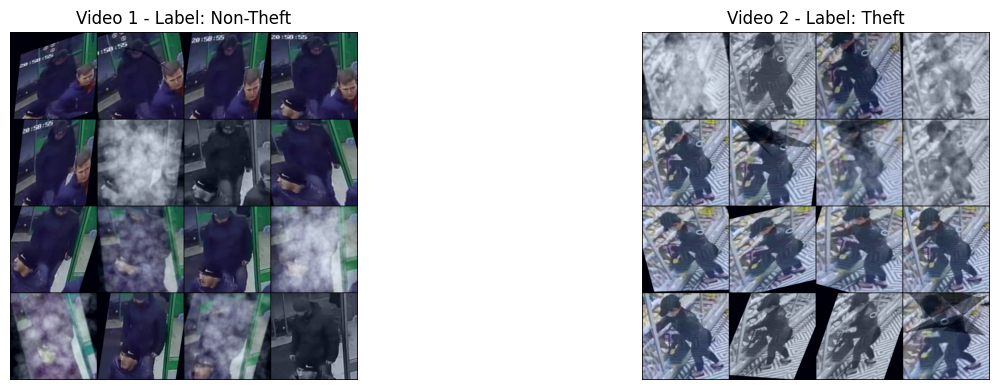

In [ ]:
theft_folder = "data/theif_16"
non_theft_folder = "data/normal_16"

batch_size = 2
dataloader = get_dataloader(theft_folder, non_theft_folder, batch_size=batch_size, shuffle=True)

video_batch, labels = next(iter(dataloader))
fig, axes = plt.subplots(1, min(batch_size, 2), figsize=(15, 4))

if batch_size == 1:
    axes = [axes]
elif batch_size > 1:
    axes = axes.flatten()  


for i in range(min(batch_size, 2)):
    video = video_batch[i]
    
    mean = torch.tensor([0.45, 0.45, 0.45]).view(1, 3, 1, 1)
    std = torch.tensor([0.225, 0.225, 0.225]).view(1, 3, 1, 1)
    video = video * std + mean  
    video = video.clamp(0, 1) 
    
    grid = torchvision.utils.make_grid(video, nrow=4, padding=2) 
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy()) 
    axes[i].set_title(f"Video {i+1} - Label: {'Theft' if labels[i].item() == 1 else 'Non-Theft'}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 🤖 The Model: VideoMAE

We use the **VideoMAE (Masked Autoencoders for Video)** model as the foundation for our classifier.

* This model is specifically designed for video understanding and requires a **16-frame input** sequence.
* We've adapted the original architecture by **replacing the final classification layer** to output predictions for our two target classes: `Theft` and `Normal`.

In [ ]:
model = VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base-finetuned-kinetics",
    attn_implementation="sdpa",
)
model.classifier = torch.nn.Linear(model.config.hidden_size, 2)
model.config.num_labels = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 2e-5
num_epochs = 30
batch_size = 4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

train_dataloader = get_dataloader('data/theif_16', 'data/normal_16', batch_size=batch_size, shuffle=True)

### The Training Loop

In [ ]:
load_model = True 
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "best_model.pth")

best_accuracy = 0.0

if load_model and os.path.exists(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    total_loss_history = checkpoint['total_loss_history']
    total_accuracy_history = checkpoint['total_accuracy_history']
    best_accuracy = checkpoint.get('best_accuracy', 0.0) 
    print(f"Loaded model from epoch {checkpoint['epoch']}, loss: {checkpoint['total_loss_history'][-1]:.4f}, accuracy: {checkpoint['total_accuracy_history'][-1]:.4f}, best accuracy: {best_accuracy:.4f}")
else:
    start_epoch = 0
    total_loss_history = []
    total_accuracy_history = []

model.train() 

for epoch in range(start_epoch, num_epochs):
    total_loss = 0
    correct = 0
    total_samples = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (videos, labels) in enumerate(progress_bar):
      
        videos = videos.to(device, dtype=torch.float32)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(videos)
        outputs = outputs.logits
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        batch_accuracy = correct / total_samples
        
        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)
        
        progress_bar.set_postfix({
            'loss': avg_loss,
            'acc': batch_accuracy
        })

    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = correct / total_samples
    total_loss_history.append(epoch_loss)
    total_accuracy_history.append(epoch_accuracy)
    
    
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'total_loss_history': total_loss_history,
            'total_accuracy_history': total_accuracy_history,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'best_accuracy': best_accuracy  
        }, model_path)
        

final_model_path = os.path.join(save_dir, "final_model.pth")
torch.save({
    'epoch': num_epochs - 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'total_loss_history': total_loss_history,
    'total_accuracy_history': total_accuracy_history,
    'loss': total_loss_history[-1],
    'accuracy': total_accuracy_history[-1],
    'best_accuracy': best_accuracy  
}, final_model_path)

In [ ]:
checkpoint = torch.load('saved_models/best_model.pth')
total_loss_history = checkpoint['total_loss_history']
total_accuracy_history = checkpoint['total_accuracy_history']

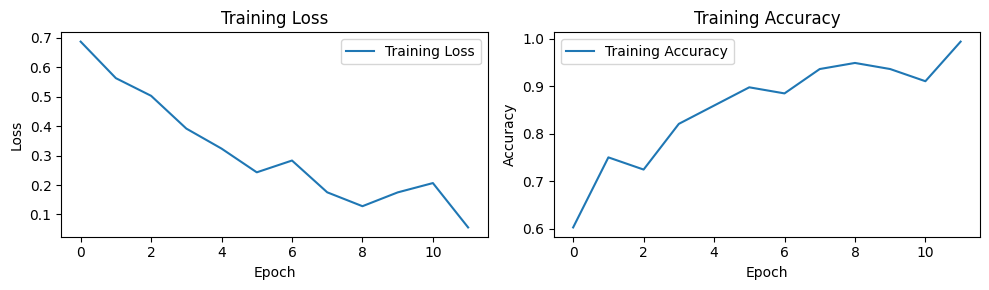

In [ ]:
plt.figure(figsize=(10, 3))

# График loss
plt.subplot(1, 2, 1)
plt.plot(total_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(total_accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 🎥 Application Pipeline

Here’s how the model can be integrated into a  surveillance system:

1.  **Detection & Tracking**: A **YOLO model** first detects and tracks individuals in the video feed.
2.  **Cropping**: A slightly enlarged bounding box is cropped around the tracked person.
3.  **Classification**: The cropped video stream is fed into our classifier. It analyzes video in **90-frame chunks**, using a sliding window approach: every 30 frames, the oldest 30 are removed and 30 new ones are added.

In [3]:
VIDEO_PATH = "for_test/test_4 - Trim.mp4"
OUTPUT_PATH = "results/test_4.mp4"
CHUNK_SIZE = 90  
STEP_SIZE = 30   
CLASSIFIER_FRAMES = 16 


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tracker_model = YOLO("yolo11l.pt") 


classifier_model = VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base-finetuned-kinetics",
    attn_implementation="sdpa",
)

classifier_model.classifier = torch.nn.Linear(classifier_model.config.hidden_size, 2)
classifier_model.config.num_labels = 2

checkpoint = torch.load("saved_models/best_model.pth")
classifier_model.load_state_dict(checkpoint['model_state_dict'])


classifier_model.to(DEVICE, dtype=torch.float16)
classifier_model.eval() 

image_processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

def create_video_crop(track_history, track_id, all_frames_in_queue):
    crop_frames = []
    frame_map = {idx: frame for idx, frame in all_frames_in_queue}

    for frame_idx, box in track_history[track_id]:
        if frame_idx in frame_map:
            frame = frame_map[frame_idx]
            x1, y1, x2, y2 = map(int, box)
            
            frame_h, frame_w, _ = frame.shape
            box_w, box_h = x2 - x1, y2 - y1
            
            expand_w, expand_h = box_w * 0.1, box_h * 0.1
            
            new_x1 = max(0, int(x1 - expand_w / 2))
            new_y1 = max(0, int(y1 - expand_h / 2))
            new_x2 = min(frame_w, int(x2 + expand_w / 2))
            new_y2 = min(frame_h, int(y2 + expand_h / 2))
            
            crop = frame[new_y1:new_y2, new_x1:new_x2]
            if crop.size > 0:
                crop_frames.append(crop)
    return crop_frames

def sample_frames(video_crop, num_samples):
    if not video_crop:
        return []
    indices = np.linspace(0, len(video_crop) - 1, num_samples, dtype=int)
    return [video_crop[i] for i in indices]

def visualize_results(frame, track_history, track_predictions, frame_idx):
    for track_id, history in track_history.items():
        last_pos = None
        for f_idx, box in reversed(history):
            if f_idx == frame_idx:
                last_pos = box
                break
        
        if last_pos is not None:
            x1, y1, x2, y2 = map(int, last_pos)
            label = f"ID: {track_id}"
            color = (0, 255, 0)

            if track_id in track_predictions:
                class_id = track_predictions[track_id]
                class_name = "THIEF" if class_id == 1 else "OK"
                label += f" - {class_name}"
                if class_id == 1:
                    color = (0, 0, 255)
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 1)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 0.6, color, 1)
    return frame


cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Ошибка: не удалось открыть видеофайл"

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

frame_queue = deque(maxlen=CHUNK_SIZE)
track_history = defaultdict(list)
track_predictions = {}
frame_counter = 0

results_generator = tracker_model.track(
    source=VIDEO_PATH,
    classes=0,  
    conf=0.5, 
    iou=0.5, 
    stream=True, 
    persist=True, 
    verbose=False
)


for results in results_generator:
    frame = results.orig_img
    frame_queue.append((frame_counter, frame.copy()))
    
    if results.boxes.id is not None:
        boxes = results.boxes.xyxy.cpu().numpy()
        track_ids = results.boxes.id.cpu().numpy().astype(int)
        
        for box, track_id in zip(boxes, track_ids):
            track_history[track_id].append((frame_counter, box))

    if frame_counter > 0 and frame_counter % STEP_SIZE == 0 and len(frame_queue) == CHUNK_SIZE:
        
        start_frame_of_chunk = frame_counter - CHUNK_SIZE + 1
        active_ids = {
            tid for tid, history in track_history.items() 
            if any(f_idx >= start_frame_of_chunk for f_idx, _ in history)
        }

        for track_id in active_ids:
            video_crop = create_video_crop(track_history, track_id, frame_queue)
            if len(video_crop) < CLASSIFIER_FRAMES: continue

            sampled_crop = sample_frames(video_crop, CLASSIFIER_FRAMES)
            
            try:
                inputs = image_processor(sampled_crop, return_tensors="pt")
                inputs = {k: v.to(DEVICE, dtype=torch.float16) for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = classifier_model(**inputs)
                    probabilities = torch.softmax(outputs.logits, dim=-1)
                    prob_class_1 = probabilities[0][1].item()
                  
                    if prob_class_1 >= 0.55:
                        predicted_class_idx = 1
                    else:
                        predicted_class_idx = 0
                        
                    track_predictions[track_id] = predicted_class_idx
                    
                track_predictions[track_id] = predicted_class_idx
                print(f"  Трек ID {track_id}: класс {predicted_class_idx}")
            except Exception as e:
                print(f"Ошибка классификации для трека {track_id}: {e}")

    visualized_frame = visualize_results(frame, track_history, track_predictions, frame_counter)
    out.write(visualized_frame)
    frame_counter += 1

cap.release()
out.release()
cv2.destroyAllWindows()

  Трек ID 2: класс 1
  Трек ID 2: класс 1
  Трек ID 2: класс 1
